<h1> GNN Initial Training </h1>



Following a procedure loosely based on:

Some background reading and resources:
    1. https://distill.pub/2021/gnn-intro/ 
    2. https://arxiv.org/pdf/1910.02356v2.pdf

In [1]:
#use pyto_env kernel, pyto env.

import os
import json
import csv
import pandas as pd
import importlib
import pickle
import numpy as np

import torch
from torch.optim import AdamW
from torchmetrics import F1Score

import common
from common import plot_confusion_matrix, get_weights

import common_metrics
from common_metrics import plot_one_vs_one_roc


In [2]:
import importlib
importlib.reload(common)

<module 'common' from '/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis/Notebooks/common.py'>

In [3]:
project_dir = "/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis"
data_dir = os.path.join(project_dir,"Data")
model_dir = os.path.join(project_dir, "Models")

# Word embeddings
hidden_size = 300
glove_file = os.path.join(project_dir, f'Notebooks/glove.6B/glove.6B.{hidden_size}d.txt')


os.chdir(data_dir)

#L1 to integer map for label encoding
with open('target_idx.json') as f:
    data = f.read()
target_idx = json.loads(data)
idx_target = {target_idx[a]:a for a in target_idx.keys()}


# additional special tokens
with open('spec_tokens_ne.txt', 'rb') as file:
    spec_tokens = pickle.load(file)
spec_tokens = [a for a in spec_tokens if '-' not in a]

# Load from data directory
dataset = pd.read_csv('masked_data_set.csv', index_col = 0).reset_index(drop=True)
ds_tr = pd.read_csv('train.csv')
ds_vl = pd.read_csv('validation.csv')
ds_ts = pd.read_csv('test.csv')
#ds_tr = pd.concat([ds_tr, ds_vl], axis=0) # just use val set in training and test for validation. fewer operations


In [4]:
# tokenizer 

import spacy
from spacy.symbols import ORTH

nlp = spacy.load("en_core_web_sm")

# Add special case rule
for tok in spec_tokens:
    special_case = [{ORTH: tok}]
    nlp.tokenizer.add_special_case(tok, special_case)
    
# Check new tokenization
print([w.text.lower() for w in nlp("An expert in NLP, <R> states that in <MISC> this is not true.")])  

['an', 'expert', 'in', 'nlp', ',', '<r>', 'states', 'that', 'in', '<misc>', 'this', 'is', 'not', 'true', '.']


<h1> Data Helper </h1>

This class processes the dataframe for compatibility with the model, and provides a batch iterator for sampling by the training loop.

In [5]:
def tokenize_fn(text):
    # need lowercase for GloVe vectors
    return [w.text.lower() for w in nlp(text)]

class GCNDataHelper(object):
    '''
    customized from source code.
    Use with SpaCy tokenizer
    
    '''
    def __init__(self, 
                 dataset,
                 tokenize_fn, 
                 target_idx,
                 device,
                 mode='train', 
                 vocab=None):

        self.mode = mode
        self.device = device
        self.dataset = dataset# pd.DataFrame object
        self.tokenizer = tokenize_fn # bert custom trained tokenizer
        self.labels_str = target_idx
        self.label = self.label_to_onehot()
        content, label = self.get_content() 
        
        if vocab is None:
            #self.vocab = [] #necessary?
            #try:
           #     self.get_vocab()
            #except FileNotFoundError:
            self.build_vocab_and_freq(content, min_count=24)
        else:
            self.vocab = vocab
        
        self.d = dict(zip(self.vocab, range(len(self.vocab)))) # integer IDS
        self.content = self.docs_as_ids(dataset)
    
    def docs_as_ids(self, dataset):
        content = []
        for text in dataset['Text']:
            tokens = self.tokenizer(text)
            ids = [self.word2id(a) for a in tokens]
            content.append(ids)
        return content

    def label_to_onehot(self): # is this actually one-hots or label index values?
        target_indices = [self.labels_str[a] for a in self.dataset['Target']]
        return target_indices 
    
    def get_content(self):
        label = self.dataset['Target'].tolist()
        content = self.dataset['Text'].tolist()
        #content, label = zip(content, label)
        return content, label
    
    def word2id(self, word): # text from dataset

        '''
        return integer IDs for embedding lookup. 
        '''

        try:
            result = self.d[word]
        except KeyError:
            result = self.d['<unk>']

        return result

    def build_vocab_and_freq(self, dataset, min_count): # returns list of tokens only
        '''
        assigns a dictionary of frequency counts and list of tokens as vocab.
        '''
        vocab = []
        freq = {}

        for c in self.dataset['Text']:
            words = self.tokenizer(c)
            for word in words:
                if word not in vocab:
                    vocab.append(word)
                    freq[word] = 1
                else:
                    freq[word] += 1

        results = []
        for word in freq.keys():
            if freq[word] < min_count:
                continue
            else:
                results.append(word)
        results.insert(0, '<unk>')
        
        with open('gcn_vocab.txt', 'w') as f:
            f.write('\n'.join(results))
            
        with open('gcn_freq.csv', 'w') as f:
            writer = csv.writer(f)
            r = list(zip(freq.keys(), freq.values()))
            writer.writerows(r)
            
        self.vocab = results

    def batch_iter(self, batch_size, num_epoch):
        for i in range(num_epoch):
            num_per_epoch = int(len(self.content) / batch_size)
            for batch_id in range(num_per_epoch):
                start = batch_id * batch_size
                end = min((batch_id + 1) * batch_size, len(self.content))

                content = self.content[start:end]
                label = self.label[start:end]

                yield content, torch.tensor(label).to(device), i


<h1> PMI - (Positive) Pointwise Mutual Information </h1>

More information:
https://en.wikipedia.org/wiki/Pointwise_mutual_information


In [6]:
def cal_PMI(helper, window_size=50):
    '''
    
    calculate Positive Pointwise Mutual Information across the dataset.
    Inputs: object of GCNDataHelper class
    Outputs: edge weights, edge mappings, and counts number of edges
    
    '''
    len_vocab = len(helper.vocab)
    pair_count_matrix = np.zeros((len_vocab, len_vocab), dtype=int)
    word_count =np.zeros(len_vocab, dtype=int)
    
    for sample in helper.content:
        for i, word in enumerate(sample):
            try:
                word_count[word] += 1
            except KeyError:
                continue
            start_index = max(0, i - window_size)
            end_index = min(len(sample), i + window_size)
            for j in range(start_index, end_index):
                if i == j:
                    continue
                else:
                    target_word = sample[j]
                    try:
                        pair_count_matrix[word, target_word] += 1
                    except KeyError:
                        continue
        
    total_count = np.sum(word_count)
    word_count = word_count / total_count
    pair_count_matrix = pair_count_matrix / total_count
    
    pmi_matrix = np.zeros((len_vocab, len_vocab), dtype=float)
    for i in range(len_vocab):
        for j in range(len_vocab):
            pmi_matrix[i, j] = np.log(
                pair_count_matrix[i, j] / (word_count[i] * word_count[j]) 
            )
    
    # removes nan values due to division by zero above
    pmi_matrix = np.nan_to_num(pmi_matrix)
    
    # positive PMI - remove all negative values 
    pmi_matrix = np.maximum(pmi_matrix, 0.0)

    edges_weights = [0.0]
    count = 1
    edges_mappings = np.zeros((len_vocab, len_vocab), dtype=int)
    for i in range(len_vocab):
        for j in range(len_vocab):
            if pmi_matrix[i, j] != 0:
                edges_weights.append(pmi_matrix[i, j])
                edges_mappings[i, j] = count
                count += 1

    edges_weights = np.array(edges_weights)

    edges_weights = edges_weights.reshape(-1, 1)
    # print(edges_weights.shape)
    edges_weights = torch.Tensor(edges_weights)
    
    return edges_weights, edges_mappings, count


<h1> Model Class </h1>


In [7]:
import dgl
import torch
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import tqdm
import sys, random
import time, datetime

In [52]:
help(torch.nn.LayerNorm)

Help on class LayerNorm in module torch.nn.modules.normalization:

class LayerNorm(torch.nn.modules.module.Module)
 |  LayerNorm(normalized_shape: Union[int, List[int], torch.Size], eps: float = 1e-05, elementwise_affine: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies Layer Normalization over a mini-batch of inputs as described in
 |  the paper `Layer Normalization <https://arxiv.org/abs/1607.06450>`__
 |  
 |  .. math::
 |      y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
 |  
 |  The mean and standard-deviation are calculated over the last `D` dimensions, where `D`
 |  is the dimension of :attr:`normalized_shape`. For example, if :attr:`normalized_shape`
 |  is ``(3, 5)`` (a 2-dimensional shape), the mean and standard-deviation are computed over
 |  the last 2 dimensions of the input (i.e. ``input.mean((-2, -1))``).
 |  :math:`\gamma` and :math:`\beta` are learnable affine transform parameters of
 |  :attr:`normalized_shape` if :at

In [186]:
# Based on Mojave-pku implementation 

class Model(torch.nn.Module):
    def __init__(self,
                 helper,
                 class_num,
                 hidden_size_node,
                 n_gram,
                 drop_out,
                 edges_num,
                 edges_matrix,
                 embeddings_file,
                 device,
                 max_length=512,
                 trainable_edges=True,
                 pmi=None,
                 #cuda=True,
                 ):
        
        super(Model, self).__init__()
        self.helper = helper
        self.device = device
        #self.is_cuda = cuda
        self.vocab = self.helper.vocab
        print(len(self.vocab))
        self.seq_edge_w = torch.nn.Embedding(edges_num, 1)
        print(edges_num)
        print(pmi.shape) # is this edges_mapping?
        
        self.node_hidden = torch.nn.Embedding(len(self.vocab), hidden_size_node)
        self.edges_num = edges_num
        if trainable_edges:
            self.seq_edge_w = torch.nn.Embedding.from_pretrained(torch.ones(edges_num, 1), freeze=False)
        else:
            self.seq_edge_w = torch.nn.Embedding.from_pretrained(pmi, freeze=True)
        self.hidden_size_node = hidden_size_node
        self.node_hidden.weight.data.copy_(torch.tensor(self.load_embeddings(embeddings_file)))
        self.node_hidden.weight.requires_grad = True

        self.len_vocab = len(self.vocab)
        self.ngram = n_gram
        self.d = helper.d
        self.max_length = max_length
        self.edges_matrix = edges_matrix
        self.dropout = torch.nn.Dropout(p=drop_out)
        self.activation = torch.nn.ReLU()
        self.norm = torch.nn.LayerNorm([self.hidden_size_node])
        # what does bias = True do below?
        self.Linear = torch.nn.Linear(hidden_size_node, class_num, bias=True)

    def word2id(self, word):
        result = self.helper.word2id(word)
        return result
    
    def load_embeddings(self, embeddings_file): 
        '''
        Retrieves GloVe embeddings for each token in the vocab
        '''
        embeddings = OrderedDict({a:[] for a in self.vocab})
        with open(embeddings_file, 'r') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                if word in embeddings.keys():
                    embeddings[word] = vector
                else:
                    continue #print(word, ' not in vocabulary.')

        for a in embeddings.keys():
            if len(embeddings[a]) == 0:
                embeddings[a] = embeddings['the']

        embeddings = np.array([embeddings[a] for a in embeddings.keys()])

        return embeddings

    def add_all_edges(self, doc_ids: list, old_to_new: dict):
        edges = []
        old_edge_id = []

        local_vocab = list(set(doc_ids))

        for i, src_word_old in enumerate(local_vocab):
            src = old_to_new[src_word_old]
            for dst_word_old in local_vocab[i:]:
                dst = old_to_new[dst_word_old]
                edges.append([src, dst])
                old_edge_id.append(self.edges_matrix[src_word_old, dst_word_old])

            # self circle
            edges.append([src, src])
            old_edge_id.append(self.edges_matrix[src_word_old, src_word_old])

        return edges, old_edge_id

    def add_seq_edges(self, doc_ids: list, old_to_new: dict):
        edges = []
        old_edge_id = []
        for index, src_word_old in enumerate(doc_ids):
            src = old_to_new[src_word_old]
            for i in range(max(0, index - self.ngram), min(index + self.ngram + 1, len(doc_ids))):
                dst_word_old = doc_ids[i]
                dst = old_to_new[dst_word_old]

                # - first connect the new sub_graph
                edges.append([src, dst])
                # - then get the hidden from parent_graph
                old_edge_id.append(self.edges_matrix[src_word_old, dst_word_old]) 

            # self circle
            edges.append([src, src])
            old_edge_id.append(self.edges_matrix[src_word_old, src_word_old])

        return edges, old_edge_id

    def seq_to_graph(self, doc_ids: list) -> dgl.DGLGraph():
        '''
        input: one document with integer IDs
        output: DGL graph object
        '''
        if len(doc_ids) > self.max_length:
            doc_ids = doc_ids[:self.max_length]

        local_vocab = set(doc_ids) # unique words in the training sample

        old_to_new = dict(zip(local_vocab, range(len(local_vocab))))

        #if self.is_cuda:
        local_vocab = torch.tensor(list(local_vocab))#.to(device)
        #else:
        #    local_vocab = torch.tensor(list(local_vocab))

        sub_graph = dgl.DGLGraph()#.to(device) dgl.graph()

        sub_graph.add_nodes(len(local_vocab))
        local_node_hidden = self.node_hidden(local_vocab) # GloVe embeddings 

        sub_graph.ndata['h'] = local_node_hidden#.to(device)

        seq_edges, seq_old_edges_id = self.add_seq_edges(doc_ids, old_to_new)

        edges, old_edge_id = [], []
        # edges = []

        edges.extend(seq_edges)

        old_edge_id.extend(seq_old_edges_id)

        #if self.is_cuda:
        old_edge_id = torch.LongTensor(old_edge_id)#.to(device)
        #else:
        #    old_edge_id = torch.LongTensor(old_edge_id)

        srcs, dsts = zip(*edges)
        sub_graph.add_edges(srcs, dsts)
        try:
            seq_edges_w = self.seq_edge_w(old_edge_id)
        except RuntimeError:
            print(old_edge_id)
        sub_graph.edata['w'] = seq_edges_w
        
        return sub_graph.to(device)

    def forward(self, doc_ids, is_20ng=None, debug = False):
        sub_graphs = [self.seq_to_graph(doc) for doc in doc_ids]

        batch_graph = dgl.batch(sub_graphs)

        batch_graph.update_all(
            message_func=dgl.function.src_mul_edge('h', 'w', 'weighted_message'),
            reduce_func=dgl.function.max('weighted_message', 'h')
        )

        h1 = dgl.sum_nodes(batch_graph, feat='h')
        norm = self.norm(h1)
        drop1 = self.dropout(norm)
        act1 = self.activation(drop1)

        l = self.Linear(act1)
        if debug:
            return l, act1, drop1, norm, h1, batch_graph, sub_graphs
        else:
            return l
        

Go through the forward pass and add Layer Normalization
Is sum_nodes a sufficient operation? Why not put a linear layer here?

In [142]:
sample, _, _ = next(train_data_helper.batch_iter(2, 1))

In [181]:
l, act1, drop1, norm, h1, batch_graph, sub_graphs = model(sample)

In [182]:
act1.shape # very high values or zero

torch.Size([2, 300])

In [183]:
act1

tensor([[ 0.0000,  0.7249,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5484,  0.0000,  0.0000,
          1.1795,  1.1837,  0.0000,  0.0000,  0.0000,  1.5260,  1.6571,  0.0000,
          0.0000,  0.6131,  0.9697,  0.0000,  0.0000,  0.7204,  0.0000,  0.0000,
          0.0000,  0.4228,  0.0000,  2.0536,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.7786,  1.4657,  2.2753,  1.1049,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.5134,  0.1671,  2.4371,  0.0000,  0.0000,  1.6488,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1959,
          0.0000,  1.4599,  0.0000,  0.3722,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  6.3884,  0.2336,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0547,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [185]:
norm

tensor([[-4.3536e-01,  3.6243e-01, -1.3241e+00, -9.7232e-01, -4.7215e-01,
          1.7033e-01,  7.4182e-02,  7.7876e-01,  5.6975e-01, -4.6193e+00,
          3.7180e-01, -2.0010e-01, -1.2066e+00,  2.7422e-01,  2.6186e-02,
          3.7196e-01,  5.8974e-01,  5.9184e-01,  1.4899e-01,  3.0590e-01,
          1.1217e-01,  7.6300e-01,  8.2854e-01,  4.9544e-01, -8.6054e-01,
          3.0653e-01,  4.8483e-01, -4.7080e-01,  9.1680e-01,  3.6021e-01,
         -7.0319e-01,  6.9038e-01, -8.6056e-01,  2.1142e-01, -2.9365e+00,
          1.0268e+00, -2.3977e-01, -9.2623e-01, -5.9378e-01,  1.5448e-01,
         -3.4534e-02, -6.5374e-01, -2.7875e-01,  5.3590e-01,  3.8928e-01,
          7.3284e-01,  1.1377e+00,  5.5245e-01, -1.0027e+00, -6.5386e-01,
          5.1745e-02, -7.9026e-01, -4.5558e-01, -8.0277e-02, -1.1798e+00,
          7.3760e-01, -2.0995e-01,  1.1770e-01,  7.5672e-01,  8.3537e-02,
          1.2185e+00, -3.7468e-01,  1.0478e+00,  8.2440e-01, -5.2329e-01,
         -5.5384e-01,  7.4127e-01,  4.

In [184]:
drop1

tensor([[-0.8707,  0.7249, -2.6481, -1.9446, -0.9443,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.4002, -0.0000,  0.5484,  0.0000,  0.0000,
          1.1795,  1.1837,  0.0000,  0.0000,  0.0000,  1.5260,  1.6571,  0.0000,
         -0.0000,  0.6131,  0.9697, -0.0000,  0.0000,  0.7204, -0.0000,  0.0000,
         -0.0000,  0.4228, -5.8730,  2.0536, -0.4795, -1.8525, -1.1876,  0.0000,
         -0.0691, -0.0000, -0.5575,  0.0000,  0.7786,  1.4657,  2.2753,  1.1049,
         -2.0054, -1.3077,  0.0000, -1.5805, -0.0000, -0.0000, -2.3597,  0.0000,
         -0.0000,  0.0000,  1.5134,  0.1671,  2.4371, -0.0000,  0.0000,  1.6488,
         -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1959,
         -2.1680,  1.4599, -0.0000,  0.3722,  0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000,  6.3884,  0.2336, -0.0000, -0.6898, -0.1143,  0.0000,
         -1.0305, -1.4778,  0.0000,  1.0547, -2.0378, -0.0000,  0.0000, -0.0000,
         -2.1399, -0.0000,  

In [154]:
torch.sum(act1 == 0.0)

tensor(309)

In [156]:
h1.shape

torch.Size([2, 300])

In [157]:
h1

tensor([[  92.7139,  118.2343,   64.2856,   75.5373,   91.5371,  112.0891,
          109.0136,  131.5521,  124.8662,  -41.1248,  118.5339,  100.2397,
           68.0442,  115.4125,  107.4782,  118.5392,  125.5055,  125.5728,
          111.4066,  116.4260,  110.2287,  131.0481,  133.1445,  122.4891,
           79.1129,  116.4462,  122.1497,   91.5801,  135.9678,  118.1634,
           84.1465,  128.7252,   79.1121,  113.4036,   12.7047,  139.4874,
           98.9706,   77.0116,   87.6461,  111.5823,  105.5359,   85.7282,
           97.7238,  123.7835,  119.0933,  130.0832,  143.0329,  124.3129,
           74.5646,   85.7243,  108.2958,   81.3611,   92.0671,  104.0726,
           68.8989,  130.2355,   99.9246,  110.4055,  130.8472,  109.3128,
          145.6199,   94.6549,  140.1584,  133.0121,   89.9010,   88.9239,
          130.3529,  119.4663,  112.7132,  122.4487,  111.6463,  109.7733,
           71.9654,  129.9912,   97.1257,  112.5929,  125.5140,  111.0485,
           76.7359,  110.

In [159]:
help(batch_graph)

Help on DGLHeteroGraph in module dgl.heterograph object:

class DGLHeteroGraph(builtins.object)
 |  DGLHeteroGraph(gidx=[], ntypes=['_N'], etypes=['_E'], node_frames=None, edge_frames=None, **deprecate_kwargs)
 |  
 |  Class for storing graph structure and node/edge feature data.
 |  
 |  There are a few ways to create a DGLGraph:
 |  
 |  * To create a homogeneous graph from Tensor data, use :func:`dgl.graph`.
 |  * To create a heterogeneous graph from Tensor data, use :func:`dgl.heterograph`.
 |  * To create a graph from other data sources, use ``dgl.*`` create ops. See
 |    :ref:`api-graph-create-ops`.
 |  
 |  Read the user guide chapter :ref:`guide-graph` for an in-depth explanation about its
 |  usage.
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, vid)
 |      **DEPRECATED**: please directly call :func:`has_nodes`.
 |  
 |  __copy__(self)
 |      Shallow copy implementation.
 |  
 |  __getitem__(self, key)
 |      Return the relation slice of this graph.
 |      
 |

In [166]:
batch_graph

Graph(num_nodes=369, num_edges=43212,
      ndata_schemes={'h': Scheme(shape=(300,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(1,), dtype=torch.float32)})

In [167]:
sub_graphs

[Graph(num_nodes=167, num_edges=17238,
       ndata_schemes={'h': Scheme(shape=(300,), dtype=torch.float32)}
       edata_schemes={'w': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=202, num_edges=25974,
       ndata_schemes={'h': Scheme(shape=(300,), dtype=torch.float32)}
       edata_schemes={'w': Scheme(shape=(1,), dtype=torch.float32)})]

In [171]:
help(batch_graph)

Help on DGLHeteroGraph in module dgl.heterograph object:

class DGLHeteroGraph(builtins.object)
 |  DGLHeteroGraph(gidx=[], ntypes=['_N'], etypes=['_E'], node_frames=None, edge_frames=None, **deprecate_kwargs)
 |  
 |  Class for storing graph structure and node/edge feature data.
 |  
 |  There are a few ways to create a DGLGraph:
 |  
 |  * To create a homogeneous graph from Tensor data, use :func:`dgl.graph`.
 |  * To create a heterogeneous graph from Tensor data, use :func:`dgl.heterograph`.
 |  * To create a graph from other data sources, use ``dgl.*`` create ops. See
 |    :ref:`api-graph-create-ops`.
 |  
 |  Read the user guide chapter :ref:`guide-graph` for an in-depth explanation about its
 |  usage.
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, vid)
 |      **DEPRECATED**: please directly call :func:`has_nodes`.
 |  
 |  __copy__(self)
 |      Shallow copy implementation.
 |  
 |  __getitem__(self, key)
 |      Return the relation slice of this graph.
 |      
 |

In [174]:
sub_graphs[0].adj()

tensor(indices=tensor([[  1,   1,   1,  ..., 166, 166, 166],
                       [  1,   2,   3,  ...,  44, 166, 166]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(167, 167), nnz=17238, layout=torch.sparse_coo)

<h1> Training Loop </h1>



In [9]:
def get_time_dif(start_time):
    """for calculating training time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return datetime.timedelta(seconds=int(round(time_dif)))

In [10]:
def dev(model, val_data_helper, mode='val'):
    #data_helper = DataHelper(dataset, mode='dev')

    total_pred = 0
    correct = 0
    iteration = 0
    preds = []
    labels = []
    for content, label, _ in val_data_helper.batch_iter(batch_size=batch_size, num_epoch=1):
        iteration += 1
        model.eval()

        logits = model(content)
        pred = torch.argmax(logits, dim=1)
        preds.extend(pred)
        labels.extend(label)
        correct_pred = torch.sum(pred == label)

        correct += correct_pred
        total_pred += len(content)

    total_pred = float(total_pred)
    correct = correct.float()
    acc = torch.div(correct, total_pred).to('cpu')
    #print(torch.div(correct, total_pred))
    if mode=='test':
        print(acc)
        return preds, labels
    else:
        return acc

ADD A LR SCHEDULER

In [12]:
def train(model,
          ngram, 
          name, 
          bar, 
          drop_out, 
          train_data_helper,
          val_data_helper,
          device, 
          edges=True):

    print(model)
    print('device: ', device)
    model.to(device)
    

    iteration = 0
    if bar:
        pbar = tqdm.tqdm(total=NUM_ITER_EVAL)
    best_acc = 0.0
    last_best_epoch = 0
    start_time = time.time()
    total_loss = 0.0
    total_correct = 0
    total = 0
    
    for content, label, epoch in train_data_helper.batch_iter(batch_size=batch_size, num_epoch=epochs):
        improved = ''
        model.train()

        logits = model(content)
        loss = loss_func(logits, label)

        pred = torch.argmax(logits, dim=1)

        correct = torch.sum(pred == label)

        total_correct += correct
        total += len(label)

        total_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

        iteration += 1
        if bar:
            pbar.update()
        if iteration % NUM_ITER_EVAL == 0:
            if bar:
                pbar.close()

            val_acc = dev(model, val_data_helper, mode='val')
            if val_acc > best_acc:
                best_acc = val_acc
                last_best_epoch = epoch
                improved = '*'

                torch.save(model, name + '.pkl')

            if epoch - last_best_epoch >= EARLY_STOP_EPOCH:
                return name
            msg = 'Epoch: {0:>6} Iter: {1:>6}, Train Loss: {5:>7.2}, Train Acc: {6:>7.2%}' \
                  + 'Val Acc: {2:>7.2%}, Time: {3}{4}'

            print(msg.format(epoch, #0
                             iteration, #1
                             val_acc, #2
                             get_time_dif(start_time), #3
                             improved, #4
                             total_loss / NUM_ITER_EVAL, #5
                             float(total_correct) / float(total)))  #6

            total_loss = 0.0
            total_correct = 0
            total = 0
            if bar:
                pbar = tqdm.tqdm(total=NUM_ITER_EVAL)

    return name

<h1> Train </h1>

In [213]:
# training hyperparameters

ngram = 60 # this is used for the doc-specific graphs
window_size = 15 # this feeds the PMI and edge mappings
dropout = 0.20
batch_size = 2
lr = 1e-4
epochs = 30
max_len = 512
hidden_size_node = hidden_size
edges = True # whether node edges are trainable
n_classes = len(target_idx.keys())
#mps = 'mps' if torch.has_mps else 'cpu'
device = 'cpu' # torch.device(mps)
weight_decay = 1e-2
weights = get_weights(ds_tr, target_idx)

NUM_ITER_EVAL = 5000
EARLY_STOP_EPOCH = 25

GE    0.877503
SP    0.925578
CN    0.947032
RU    1.051821
JP    1.084146
AR    1.113921
Name: Target, dtype: float64


In [206]:
train_data_helper

In [66]:
train_data_helper = GCNDataHelper(ds_tr, 
                            tokenize_fn = tokenize_fn, 
                            target_idx=target_idx, 
                            device = device,
                            mode='train')

val_data_helper = GCNDataHelper(ds_vl,
                            tokenize_fn = tokenize_fn, 
                            target_idx=target_idx, 
                            device = device,
                            mode='dev')

test_data_helper = GCNDataHelper(ds_ts,
                               tokenize_fn = tokenize_fn, 
                            target_idx=target_idx, 
                            device = device,
                            mode='test')

In [188]:
edges_weights, edges_mappings, count = cal_PMI(train_data_helper, window_size = window_size)

/var/folders/5h/lrwcctsx1xv_r4qlss7b9mt80000gp/T/ipykernel_11251/871596858.py:38: RuntimeWarning: divide by zero encountered in log
  pmi_matrix[i, j] = np.log(


In [214]:
model = Model(helper = train_data_helper,
              class_num=n_classes, 
              hidden_size_node=hidden_size_node,
              n_gram=ngram, 
              drop_out=dropout, 
              edges_num=count,
              edges_matrix=edges_mappings,   
              embeddings_file = glove_file,
              device = device,
              max_length = max_len,
              trainable_edges=edges, 
              pmi=edges_weights,
              )

6112
5898917
torch.Size([5898917, 1])


In [218]:
# weighted cross entropy
loss_func = torch.nn.CrossEntropyLoss(weight = weights)
#loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)

In [219]:
training_1 = train(model,
              ngram = ngram, 
              name = 'textGCN_initial_1',
              bar = True,
              drop_out=dropout, 
              train_data_helper=train_data_helper, 
              val_data_helper=val_data_helper,
              device=device, 
              edges=edges
             )

Model(
  (seq_edge_w): Embedding(5898917, 1)
  (node_hidden): Embedding(6112, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
  (norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (Linear): Linear(in_features=300, out_features=6, bias=True)
)
device:  cpu


100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [11:40<00:00,  7.14it/s]


Epoch:      0 Iter:   5000, Train Loss:     1.6, Train Acc:  37.96%Val Acc:  18.91%, Time: 0:13:13*


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:04<00:00,  5.92it/s]


Epoch:      1 Iter:  10000, Train Loss:     1.6, Train Acc:  35.30%Val Acc:  25.57%, Time: 0:28:51*


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:34<00:00,  5.72it/s]


Epoch:      2 Iter:  15000, Train Loss:     1.6, Train Acc:  37.95%Val Acc:  26.45%, Time: 0:44:56*


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:47<00:00,  7.07it/s]


Epoch:      2 Iter:  20000, Train Loss:     1.6, Train Acc:  35.84%Val Acc:  23.49%, Time: 0:58:13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:06<00:00,  6.88it/s]


Epoch:      3 Iter:  25000, Train Loss:     1.5, Train Acc:  43.23%Val Acc:  27.05%, Time: 1:11:52*


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:10<00:00,  5.88it/s]


Epoch:      4 Iter:  30000, Train Loss:     1.3, Train Acc:  49.82%Val Acc:  23.96%, Time: 1:27:33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:54<00:00,  5.99it/s]


Epoch:      5 Iter:  35000, Train Loss:     1.2, Train Acc:  58.72%Val Acc:  23.76%, Time: 1:42:57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:52<00:00,  7.67it/s]


Epoch:      5 Iter:  40000, Train Loss:     1.2, Train Acc:  57.34%Val Acc:  24.50%, Time: 1:55:19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:48<00:00,  6.51it/s]


Epoch:      6 Iter:  45000, Train Loss:    0.95, Train Acc:  66.92%Val Acc:  26.04%, Time: 2:09:39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:12<00:00,  5.86it/s]


Epoch:      7 Iter:  50000, Train Loss:    0.81, Train Acc:  73.10%Val Acc:  24.43%, Time: 2:25:22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:14<00:00,  6.80it/s]


Epoch:      7 Iter:  55000, Train Loss:    0.85, Train Acc:  70.60%Val Acc:  24.50%, Time: 2:39:05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:25<00:00,  7.30it/s]


Epoch:      8 Iter:  60000, Train Loss:    0.84, Train Acc:  70.63%Val Acc:  23.76%, Time: 2:52:01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:45<00:00,  6.06it/s]


Epoch:      9 Iter:  65000, Train Loss:    0.66, Train Acc:  78.61%Val Acc:  24.43%, Time: 3:07:16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:57<00:00,  5.97it/s]


Epoch:     10 Iter:  70000, Train Loss:     0.6, Train Acc:  80.71%Val Acc:  24.43%, Time: 3:22:39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:52<00:00,  7.66it/s]


Epoch:     10 Iter:  75000, Train Loss:    0.76, Train Acc:  73.58%Val Acc:  24.56%, Time: 3:34:57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:43<00:00,  7.11it/s]


Epoch:     11 Iter:  80000, Train Loss:    0.66, Train Acc:  77.76%Val Acc:  25.37%, Time: 3:48:07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:41<00:00,  6.08it/s]


Epoch:     12 Iter:  85000, Train Loss:    0.53, Train Acc:  82.99%Val Acc:  22.41%, Time: 4:03:15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:07<00:00,  6.35it/s]


Epoch:     13 Iter:  90000, Train Loss:    0.55, Train Acc:  81.77%Val Acc:  24.02%, Time: 4:17:50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:37<00:00,  7.84it/s]


Epoch:     13 Iter:  95000, Train Loss:    0.66, Train Acc:  77.18%Val Acc:  25.10%, Time: 4:29:54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:35<00:00,  6.62it/s]


Epoch:     14 Iter: 100000, Train Loss:    0.54, Train Acc:  81.86%Val Acc:  24.70%, Time: 4:43:55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:46<00:00,  6.05it/s]


Epoch:     15 Iter: 105000, Train Loss:    0.47, Train Acc:  85.13%Val Acc:  21.67%, Time: 4:59:09


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:39<00:00,  7.15it/s]


Epoch:     15 Iter: 110000, Train Loss:    0.56, Train Acc:  81.14%Val Acc:  25.37%, Time: 5:12:14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:05<00:00,  7.51it/s]


Epoch:     16 Iter: 115000, Train Loss:    0.58, Train Acc:  80.55%Val Acc:  24.23%, Time: 5:24:45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:29<00:00,  6.17it/s]


Epoch:     17 Iter: 120000, Train Loss:    0.44, Train Acc:  86.24%Val Acc:  23.55%, Time: 5:39:42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:50<00:00,  6.02it/s]


Epoch:     18 Iter: 125000, Train Loss:    0.42, Train Acc:  87.05%Val Acc:  25.17%, Time: 5:54:57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:38<00:00,  7.83it/s]


Epoch:     18 Iter: 130000, Train Loss:    0.57, Train Acc:  80.80%Val Acc:  25.37%, Time: 6:07:02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:51<00:00,  7.03it/s]


Epoch:     19 Iter: 135000, Train Loss:     0.5, Train Acc:  83.73%Val Acc:  24.56%, Time: 6:20:20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:41<00:00,  6.08it/s]


Epoch:     20 Iter: 140000, Train Loss:     0.4, Train Acc:  87.49%Val Acc:  21.74%, Time: 6:35:28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:45<00:00,  6.53it/s]


Epoch:     21 Iter: 145000, Train Loss:    0.44, Train Acc:  86.01%Val Acc:  24.97%, Time: 6:49:40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:40<00:00,  7.81it/s]


Epoch:     21 Iter: 150000, Train Loss:    0.52, Train Acc:  82.21%Val Acc:  24.97%, Time: 7:01:47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:39<00:00,  6.58it/s]


Epoch:     22 Iter: 155000, Train Loss:    0.42, Train Acc:  87.22%Val Acc:  24.97%, Time: 7:15:53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:48<00:00,  6.04it/s]


Epoch:     23 Iter: 160000, Train Loss:    0.36, Train Acc:  89.03%Val Acc:  23.49%, Time: 7:31:07


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:25<00:00,  7.29it/s]


Epoch:     23 Iter: 165000, Train Loss:    0.47, Train Acc:  84.74%Val Acc:  26.18%, Time: 7:43:59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:04<00:00,  7.53it/s]


Epoch:     24 Iter: 170000, Train Loss:    0.47, Train Acc:  84.26%Val Acc:  25.57%, Time: 7:56:29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:42<00:00,  6.08it/s]


Epoch:     25 Iter: 175000, Train Loss:    0.36, Train Acc:  89.05%Val Acc:  24.56%, Time: 8:11:39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:51<00:00,  6.02it/s]


Epoch:     26 Iter: 180000, Train Loss:    0.34, Train Acc:  89.59%Val Acc:  25.91%, Time: 8:26:54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:30<00:00,  7.93it/s]


Epoch:     26 Iter: 185000, Train Loss:    0.48, Train Acc:  84.61%Val Acc:  26.18%, Time: 8:38:49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:55<00:00,  6.99it/s]


Epoch:     27 Iter: 190000, Train Loss:    0.41, Train Acc:  86.92%Val Acc:  25.24%, Time: 8:52:11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:42<00:00,  6.08it/s]


In [61]:
a, _, _, = next(train_data_helper.batch_iter(batch_size=batch_size, num_epoch=epochs))
model.eval()
_, h1 = model.forward(a)

<h1> Test </h1>

In [220]:
test_preds, test_labels = dev(model, test_data_helper, mode='test')

tensor(0.2026)


In [221]:
ds_ts['Target'].value_counts()

GE    422
SP    291
CN    272
RU    189
JP    161
AR    151
Name: Target, dtype: int64

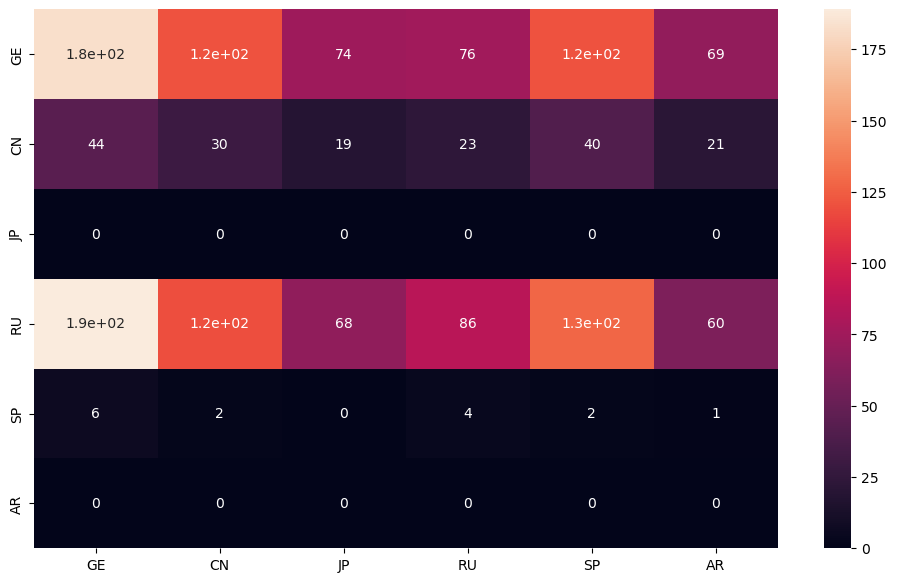

In [222]:
plot_confusion_matrix(test_preds, 
                      test_labels, 
                      idx_target)

In [54]:
q = train_data_helper.batch_iter(2, 1)

In [19]:
best_model = torch.load('textGCN_initial_1.pkl')

In [23]:
b_test_preds, b_test_labels = dev(best_model, test_data_helper, mode='test')

/Users/paulp/miniforge3/envs/pyto/lib/python3.9/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


tensor(0.2813)


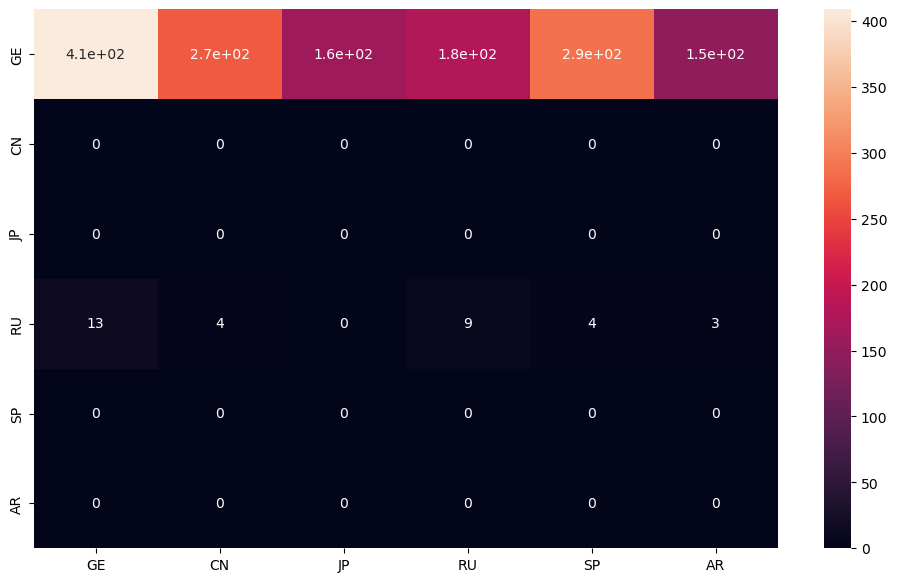

In [24]:
plot_confusion_matrix(b_test_preds, 
                      b_test_labels, 
                      idx_target)

Questions:

Why isn't validation working?
What is the relationship between Loss and train accuracty? Why don't these coincide?


In [ ]:
# necessary?
def edges_mapping(vocab_len, content, ngram):
    count = 1
    mapping = np.zeros(shape=(vocab_len, vocab_len), dtype=np.int32)
    for doc in content:
        for i, src in enumerate(doc):
            for dst_id in range(max(0, i-ngram), min(len(doc), i+ngram+1)):
                dst = doc[dst_id]

                if mapping[src, dst] == 0:
                    mapping[src, dst] = count
                    count += 1

    for word in range(vocab_len):
        mapping[word, word] = count
        count += 1

    return count, mapping

In [ ]:
def word_eval():
    print('load model from file.')
    data_helper = DataHelper('r8')
    edges_num, edges_matrix = edges_mapping(len(data_helper.vocab), data_helper.content, 1)
    model = torch.load(os.path.join('word_eval_1.pkl'))

    edges_weights = model.seq_edge_w.weight.to('cpu').detach().numpy()

    core_word = 'billion'
    core_index = data_helper.vocab.index(core_word)

    results = {}
    for i in range(len(data_helper.vocab)):
        word = data_helper.vocab[i]
        n_word = edges_matrix[i, core_index]
        # n_word = edges_matrix[i, i]
        if n_word != 0:
            results[word] = edges_weights[n_word][0]

    sort_results = sorted(results.items(), key=lambda d: d[1])

    print(sort_results)

